## Exercício 2 - Q Learning


In [25]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

random.seed(123)
np.random.seed(123)

# 2
### a)

In [26]:
# baseado no ex1

GRID_ROWS = 10
GRID_COLS = 10

START_STATE = 1
GOAL_STATE = 100

ACTIONS = ["up", "down", "left", "right"]
ACTION_DELTAS = {
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1)
}

def state_to_coords(state):
    row = (state - 1) // GRID_COLS
    col = (state - 1) % GRID_COLS
    return row, col

def coords_to_state(row, col):
    return row * GRID_COLS + col + 1

def transition(state, action):
    row, col = state_to_coords(state)
    dr, dc = ACTION_DELTAS[action]
    new_row = row + dr
    new_col = col + dc
    if not (0 <= new_row < GRID_ROWS and 0 <= new_col < GRID_COLS):
        return state
    return coords_to_state(new_row, new_col)

def reward(state):
    return 100 if state == GOAL_STATE else 0

def random_action():
    return random.choice(ACTIONS)



In [27]:

# Dimensões
N_STATES = GRID_ROWS * GRID_COLS    # = 100 (10x10)
N_ACTIONS = len(ACTIONS)            # = 4  

ACTION_INDEX = {a: i for i, a in enumerate(ACTIONS)}

# alfa e gama dados do enunciado
ALPHA = 0.7    # taxa de aprendizagem
GAMMA = 0.99   # fator de desconto

# criaçao da matriz Q 
def create_q_table():
    Q = np.zeros((N_STATES, N_ACTIONS), dtype=float)
    return Q

def environment_step(state, action):

    next_state = transition(state, action)
    r = reward(next_state)
    done = (next_state == GOAL_STATE)
    return next_state, r, done


# escolhe a melhor ação
def greedy_action(Q, state):
    s_idx = state - 1
    q_values = Q[s_idx, :]
    max_q = np.max(q_values)
    best_indices = np.where(q_values == max_q)[0]
    chosen_idx = random.choice(best_indices)
    return ACTIONS[chosen_idx]

# atualiza o Q state com base na transição state -> next_state
def q_learning_update(Q, state, action, next_state):
    s_idx = state - 1
    s_next_idx = next_state - 1
    a_idx = ACTION_INDEX[action]
    r = reward(next_state)
    max_q_next = np.max(Q[s_next_idx, :])
    current_q = Q[s_idx, a_idx]
    target = r + GAMMA * max_q_next
    new_q = (1 - ALPHA) * current_q + ALPHA * target
    Q[s_idx, a_idx] = new_q

In [28]:
MAX_STEPS_PER_EPISODE = 1000   

# usa a politica greedy atual 
def run_greedy_test(Q, num_steps=1000):
    state = START_STATE
    total_reward = 0
    steps = 0

    while steps < num_steps:
        action = greedy_action(Q, state)
        next_state, r, done = environment_step(state, action)

        total_reward += r
        steps += 1
        if done:
            state = START_STATE
        else:
            state = next_state

    mean_reward = total_reward / num_steps
    return mean_reward

In [29]:

#dados do enuncido
CHECKPOINTS = [100, 200, 500, 600, 700, 800, 900, 1000,
               2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

N_EXPERIMENTS = 30
TRAINING_STEPS = 20000

rewards_at_checkpoints_random = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
execution_times_random = np.zeros(N_EXPERIMENTS)
Q_final_random = None

for exp in range(N_EXPERIMENTS):
    start_t = time.time()
    Q = create_q_table()
    state = START_STATE
    steps_in_episode = 0
    checkpoint_idx = 0

    # ciclo de treino: 20000 
    for step in range(1, TRAINING_STEPS + 1):
        action = random_action()
        next_state, r, done = environment_step(state, action)
        q_learning_update(Q, state, action, next_state)
        steps_in_episode += 1
        if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
            state = START_STATE
            steps_in_episode = 0
        else:
            state = next_state
        if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
            mean_r = run_greedy_test(Q, num_steps=1000)
            rewards_at_checkpoints_random[exp, checkpoint_idx] = mean_r
            checkpoint_idx += 1
    end_t = time.time()
    execution_times_random[exp] = end_t - start_t

    # na última experiência, guardar Q final para o heatmap
    if exp == N_EXPERIMENTS - 1:
        Q_final_random = Q.copy()

## Plots 

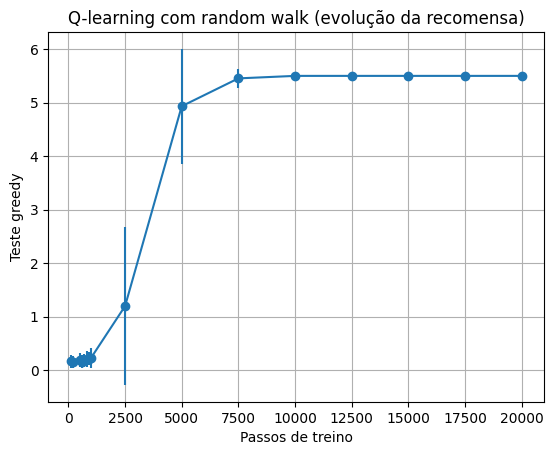

In [30]:
mean_rewards_random = rewards_at_checkpoints_random.mean(axis=0)
std_rewards_random = rewards_at_checkpoints_random.std(axis=0)

#Evolução da recompensa média
plt.figure()
plt.errorbar(CHECKPOINTS, mean_rewards_random, yerr=std_rewards_random, fmt='-o')
plt.xlabel("Passos de treino")
plt.ylabel("Teste greedy")
plt.title("Q-learning com random walk (evolução da recomensa)")
plt.grid(True)
plt.show()

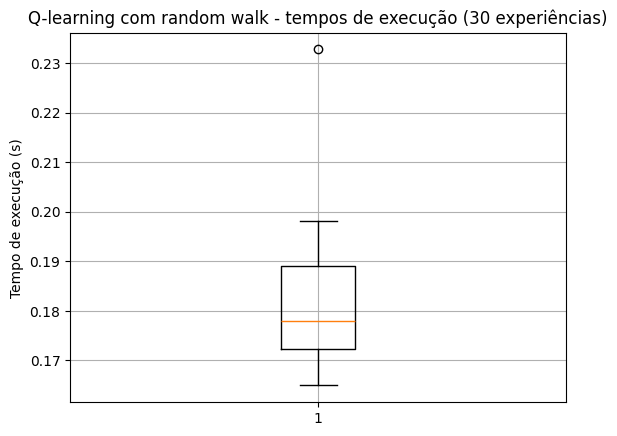

In [31]:

# plot - Tempos de execução (random walk)
plt.figure()
plt.boxplot(execution_times_random, vert=True)
plt.ylabel("Tempo de execução (s)")
plt.title("Q-learning com random walk - tempos de execução (30 experiências)")
plt.grid(True)
plt.show()


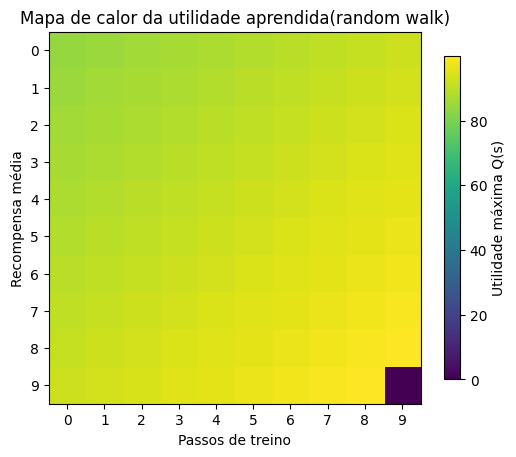

In [32]:
# Heatmap da utilidade final 

# utilidade por estado: U(s) = max_a Q(s,a)
max_q_per_state_random = Q_final_random.max(axis=1)   # vetor com 100 valores

# transformar vetor (100,) em matriz 10x10 para corresponder à grelha
heatmap_data_random = max_q_per_state_random.reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(6, 6))
plt.imshow(heatmap_data_random, origin="upper")
plt.colorbar(label="Utilidade máxima Q(s)", shrink=0.7)
plt.title("Mapa de calor da utilidade aprendida(random walk)")
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média")
plt.xticks(range(GRID_COLS))
plt.yticks(range(GRID_ROWS))
plt.grid(False)
plt.show()


# 2
### b)

In [33]:
# Igual a alinea a) mas utilizando os valores da tabela Q

rewards_at_checkpoints_greedy = np.zeros((N_EXPERIMENTS, len(CHECKPOINTS)))
execution_times_greedy = np.zeros(N_EXPERIMENTS)
Q_final_greedy = None

for exp in range(N_EXPERIMENTS):
    start_t = time.time()
    Q = create_q_table()

    state = START_STATE
    steps_in_episode = 0
    checkpoint_idx = 0

    for step in range(1, TRAINING_STEPS + 1):
      # inves de random_action usamos segundo greedy_action
        action = greedy_action(Q, state)
        next_state, r, done = environment_step(state, action)
        q_learning_update(Q, state, action, next_state)
        steps_in_episode += 1
        if done or steps_in_episode >= MAX_STEPS_PER_EPISODE:
            state = START_STATE
            steps_in_episode = 0
        else:
            state = next_state
        if checkpoint_idx < len(CHECKPOINTS) and step == CHECKPOINTS[checkpoint_idx]:
            mean_r = run_greedy_test(Q, num_steps=1000)
            rewards_at_checkpoints_greedy[exp, checkpoint_idx] = mean_r
            checkpoint_idx += 1

    end_t = time.time()
    execution_times_greedy[exp] = end_t - start_t

    if exp == N_EXPERIMENTS - 1:
        Q_final_greedy = Q.copy()

## Plots

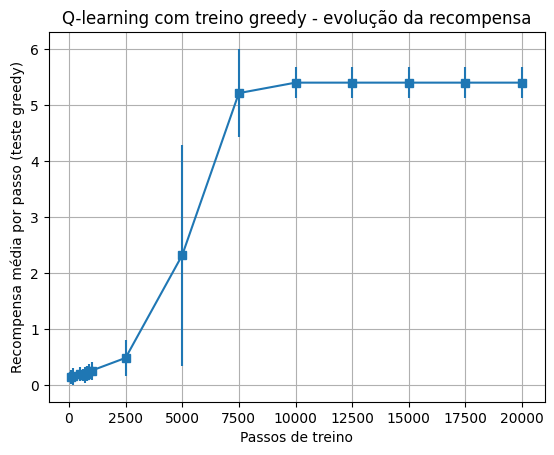

In [34]:
mean_rewards_greedy = rewards_at_checkpoints_greedy.mean(axis=0)
std_rewards_greedy = rewards_at_checkpoints_greedy.std(axis=0)

plt.figure()
plt.errorbar(CHECKPOINTS, mean_rewards_greedy, yerr=std_rewards_greedy, fmt='-s')
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Q-learning com treino greedy - evolução da recompensa")
plt.grid(True)
plt.show()

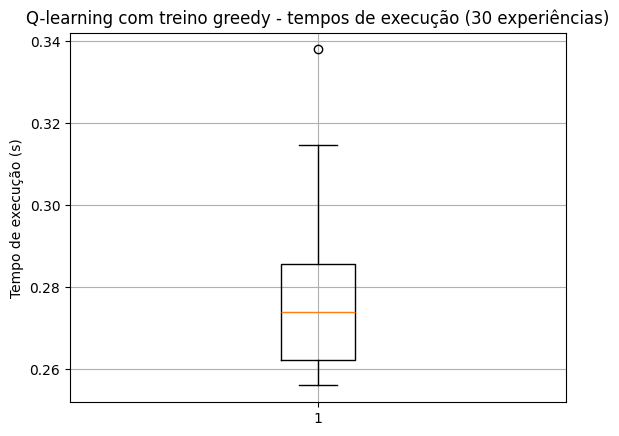

In [35]:
plt.figure()
plt.boxplot(execution_times_greedy, vert=True)
plt.ylabel("Tempo de execução (s)")
plt.title("Q-learning com treino greedy - tempos de execução (30 experiências)")
plt.grid(True)
plt.show()

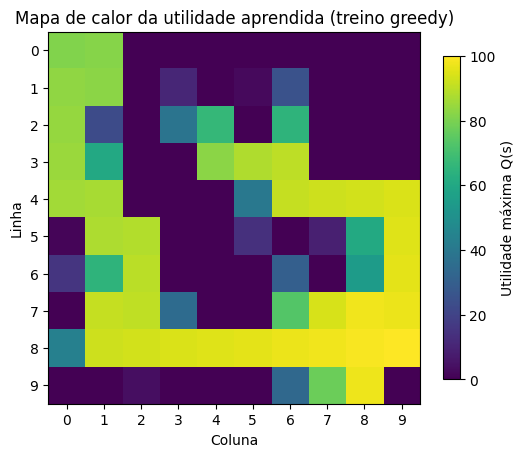

In [36]:
max_q_per_state_greedy = Q_final_greedy.max(axis=1)
heatmap_data_greedy = max_q_per_state_greedy.reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(6, 6))
plt.imshow(heatmap_data_greedy, origin="upper")
plt.colorbar(label="Utilidade máxima Q(s)", shrink=0.7)
plt.title("Mapa de calor da utilidade aprendida (treino greedy)")
plt.xlabel("Coluna")
plt.ylabel("Linha")
plt.xticks(range(GRID_COLS))
plt.yticks(range(GRID_ROWS))
plt.grid(False)
plt.show()

## Plots a) vs b)

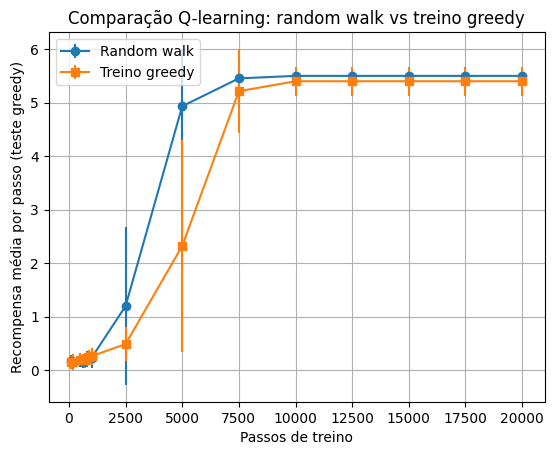

In [37]:
plt.figure()
plt.errorbar(CHECKPOINTS, mean_rewards_random, yerr=std_rewards_random, fmt='-o', label="Random walk")
plt.errorbar(CHECKPOINTS, mean_rewards_greedy, yerr=std_rewards_greedy, fmt='-s', label="Treino greedy")
plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média por passo (teste greedy)")
plt.title("Comparação Q-learning: random walk vs treino greedy")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\nicol\AppData\Local\Temp\ipykernel_19628\2597659153.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([execution_times_random, execution_times_greedy],


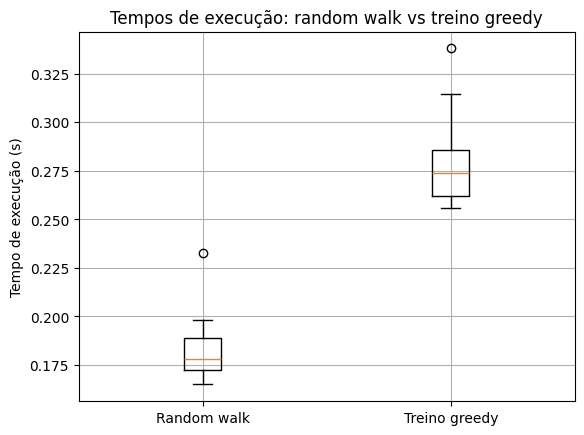

In [38]:
plt.figure()
plt.boxplot([execution_times_random, execution_times_greedy],
            labels=["Random walk", "Treino greedy"], vert=True)
plt.ylabel("Tempo de execução (s)")
plt.title("Tempos de execução: random walk vs treino greedy")
plt.grid(True)
plt.show()

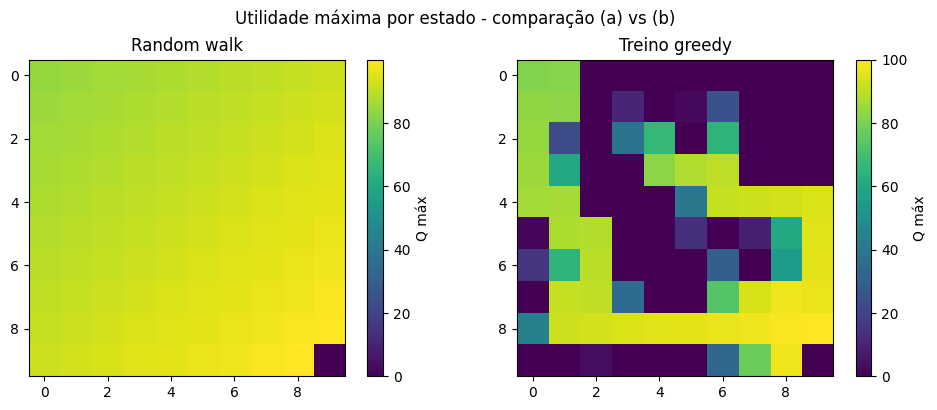

In [39]:
max_q_random = Q_final_random.max(axis=1).reshape((GRID_ROWS, GRID_COLS))
max_q_greedy = Q_final_greedy.max(axis=1).reshape((GRID_ROWS, GRID_COLS))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(max_q_random, origin="upper")
plt.title("Random walk")
plt.colorbar(label="Q máx")

plt.subplot(1, 2, 2)
plt.imshow(max_q_greedy, origin="upper")
plt.title("Treino greedy")
plt.colorbar(label="Q máx")

plt.suptitle("Utilidade máxima por estado - comparação (a) vs (b)")
plt.tight_layout()
plt.show()